In [1]:
import cv2
import sys
import json
import torch
import random
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score
from transformers import (AutoProcessor, BlipForQuestionAnswering, CLIPModel,
                          CLIPProcessor)

==============================WARNING: DEPRECATED!==============================
WARNING! This version of bitsandbytes is deprecated. Please switch to `pip install bitsandbytes` and the new repo: https://github.com/TimDettmers/bitsandbytes
==============================WARNING: DEPRECATED!==============================


In [2]:
PATH = "/data/luiz/dataset/models/animal-classifier/blip_serengeti.pth"
QUESTION = "a photo of an animal: 0) no and 1) yes"
IMAGE_PATH = "/data/luiz/dataset/serengeti_images"
METADATA_PATH = "/data/luiz/dataset/serengeti/SnapshotSerengeti_S1-11_v2.1.json"
TEST_PATH = "/data/luiz/dataset/partitions/animal-classifier/serengeti/test.csv"

metadata = pd.read_csv(TEST_PATH)
metadata.category.replace("yes", 1, inplace=True)
metadata.category.replace("no", 0, inplace=True)
metadata

,num_frames,category,location,datetime,path
0,3,1,E12,2012-10-26 12:03:13,/ssd/luiz/dataset/serengeti_images/S5/E12/E12_...
1,3,0,E11,2011-05-19 13:29:56,/ssd/luiz/dataset/serengeti_images/S2/E11/E11_...
2,3,0,N10,2012-05-16 13:27:54,/ssd/luiz/dataset/serengeti_images/S4/N10/N10_...
3,3,1,E12,2012-12-10 16:27:04,/ssd/luiz/dataset/serengeti_images/S5/E12/E12_...
4,3,0,G04,2011-02-12 13:39:42,/ssd/luiz/dataset/serengeti_images/S2/G04/G04_...
...,...,...,...,...,...
9995,3,1,N05,2011-07-07 08:31:25,/ssd/luiz/dataset/serengeti_images/S2/N05/N05_...
9996,3,0,O09,2011-11-26 14:25:55,/ssd/luiz/dataset/serengeti_images/S3/O09/O09_...
9997,3,1,M09,2010-09-20 14:45:38,/ssd/luiz/dataset/serengeti_images/S1/M09/M09_...
9998,3,1,P11,2011-07-24 10:58:51,/ssd/luiz/dataset/serengeti_images/S2/P11/P11_...


In [4]:
def apply_gamma_correction(image, gamma=1.5):
    """
    Simulates artificial lighting by adjusting image brightness non-linearly.
    Formula: output = 255 * (input / 255)^(1/gamma)
    """
    if image is None:
        raise ValueError("Input image is None. Check if the image was loaded properly.")
    
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Enhances local contrast by applying CLAHE to the luminance channel (L in LAB).
    """
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)

def apply_bilateral_filter(image, d=9, sigma_color=75, sigma_space=75):
    """
    Reduces noise while preserving edges.
    Each pixel is averaged based on spatial and color distance.
    """
    return cv2.bilateralFilter(image, d, sigma_color, sigma_space)

def apply_sharpening(image):
    """
    Enhances edges by convolving the image with a sharpening kernel.
    """
    kernel = np.array([[0, -1,  0],
                       [-1, 5, -1],
                       [0, -1,  0]])
    return cv2.filter2D(image, -1, kernel)

def apply_denoising(image, h=10):
    """
    Removes grainy noise using Non-Local Means.
    Each pixel is replaced by a weighted average of similar patches.
    """
    return cv2.fastNlMeansDenoisingColored(image, None, h, h, 7, 21)


def enhance_night_image_full(img):
    """
    Full pipeline for enhancing night images using multiple image quality techniques.
    """
    img = apply_gamma_correction(img, gamma=1.8)
    # img = apply_clahe(img)
    img = apply_bilateral_filter(img)
    # img = apply_sharpening(img)
    img = apply_denoising(img)
    return img

def get_random_samples(data, num_samples, seed=42):
    random.seed(seed)  # Set the seed for reproducibility
    return random.sample(data, num_samples)
    
def is_night(time_str):
    dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    hour = dt.hour
    return hour >= 20 or hour < 6

def get_metrics(y_true, y_pred):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

def get_image_pred_clip(image):
    model.eval()
    with torch.no_grad(): 
        inputs = processor(text=["a photo of a background", "a photo of an animal"], images=image, return_tensors="pt", padding=True).to(device)
        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image # this is the image-text similarity score
        probs = logits_per_image.softmax(dim=1).cpu().detach().numpy()[0]
        return np.argmax(probs)

def get_image_pred_blip(image):
    model.eval()
    with torch.no_grad(): 
        inputs = processor(image, QUESTION, return_tensors="pt").to(device)

        out = model.generate(**inputs)
        res = processor.decode(out[0], skip_special_tokens=True)
        return res

In [5]:
image_paths = [(
    item["path"],
    item["category"]
    ) for item in tqdm(metadata.to_dict(orient='records')) if is_night(item["datetime"])]
# image_paths = [("/data/luiz/dataset/serengeti_images/S1/B04/B04_R1/S1_B04_R1_PICT0020.JPG", 1)]
len(image_paths)

100%|██████████| 10000/10000 [00:00<00:00, 56713.43it/s]


438

# 1. CLIP

In [ ]:
PATH = "/data/luiz/dataset/models/animal-classifier/clip_serengeti.pth"
device = torch.device("cuda")

# model, processor = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base"), AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
model, processor = CLIPModel.from_pretrained("openai/clip-vit-base-patch32"), CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
model.load_state_dict(torch.load(PATH))
model.to(device)

  6%|▌         | 26/430 [00:12<02:11,  3.06it/s]

100%|██████████| 430/430 [02:23<00:00,  3.00it/s]


Using normal images:

              precision    recall  f1-score   support

           0       0.64      0.62      0.63       182
           1       0.73      0.75      0.74       248

    accuracy                           0.69       430
   macro avg       0.69      0.68      0.68       430
weighted avg       0.69      0.69      0.69       430



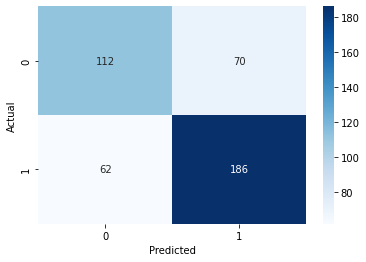

Using images with quality:

              precision    recall  f1-score   support

           0       0.62      0.70      0.66       182
           1       0.76      0.68      0.71       248

    accuracy                           0.69       430
   macro avg       0.69      0.69      0.69       430
weighted avg       0.70      0.69      0.69       430



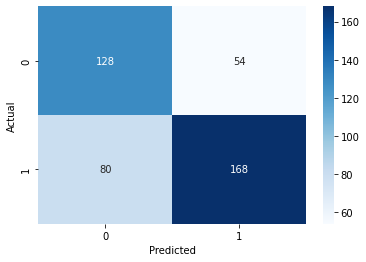

In [6]:
size = (500, 500)

paths, real, pred_quality, pred = [], [], [], []
for data in tqdm(get_random_samples(image_paths, 430)):
    path, label = data
    image = cv2.imread(path)
    if image is not None:
        enhanced = enhance_night_image_full(image)
        image = cv2.resize(image, size)
        enhanced = cv2.resize(enhanced, size)

        paths.append(path)
        real.append(str(int(label != 0)))
        pred.append(get_image_pred_clip(image))
        pred_quality.append(get_image_pred_clip(enhanced))

df_results = pd.DataFrame({"paths": paths, "real": real, "pred_quality": pred_quality, "pred": pred})

y_true = list(map(int, df_results.real)) 
y_pred = list(map(int, df_results.pred))
y_pred_quality = list(map(int, df_results.pred_quality))

print("Using normal images:\n")
get_metrics(y_true, y_pred)

print("Using images with quality:\n")
get_metrics(y_true, y_pred_quality)


# 2. BLIP

In [12]:
PATH = "/data/luiz/dataset/models/animal-classifier/blip_serengeti.pth"
device = torch.device("cuda")

model, processor = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base"), AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")
model.load_state_dict(torch.load(PATH))
model.to(device)

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0): BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): BlipEncoderLayer(
          (self_attn): BlipAttention(
     

  0%|          | 0/430 [00:00<?, ?it/s]/home/luiz/anaconda3/envs/luiz/lib/python3.9/site-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 430/430 [01:34<00:00,  4.54it/s]

Using normal images:

              precision    recall  f1-score   support

           0       0.79      0.80      0.80       182
           1       0.85      0.84      0.85       248

    accuracy                           0.83       430
   macro avg       0.82      0.82      0.82       430
weighted avg       0.83      0.83      0.83       430



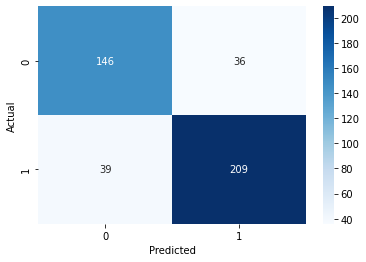

Using images with quality:

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       182
           1       0.84      0.86      0.85       248

    accuracy                           0.83       430
   macro avg       0.82      0.82      0.82       430
weighted avg       0.83      0.83      0.83       430



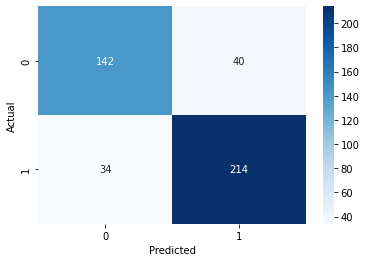

In [16]:
def enhance_night_image_full(img):
    """
    Full pipeline for enhancing night images using multiple image quality techniques.
    """
    img = apply_gamma_correction(img, gamma=1.8)
    # img = apply_clahe(img)
    # img = apply_bilateral_filter(img)
    # img = apply_sharpening(img)
    # img = apply_denoising(img)
    return img
size = (500, 500)

paths, real, pred_quality, pred = [], [], [], []
for data in tqdm(get_random_samples(image_paths, 430)):
    path, label = data
    image = cv2.imread(path)
    if image is not None:
        enhanced = enhance_night_image_full(image)
        image = cv2.resize(image, size)
        enhanced = cv2.resize(enhanced, size)

        paths.append(path)
        real.append(str(int(label != 0)))
        pred.append(get_image_pred_blip(image))
        pred_quality.append(get_image_pred_blip(enhanced))

df_results = pd.DataFrame({"paths": paths, "real": real, "pred_quality": pred_quality, "pred": pred})

y_true = list(map(int, df_results.real)) 
y_pred = list(map(int, df_results.pred))
y_pred_quality = list(map(int, df_results.pred_quality))

print("Using normal images:\n")
get_metrics(y_true, y_pred)

print("Using images with quality:\n")
get_metrics(y_true, y_pred_quality)


In [9]:
# def plot_image(path):
#     image = cv2.imread(path)

#     enhanced = enhance_night_image_full(image)
#     image = cv2.resize(image, size)
#     enhanced = cv2.resize(enhanced, size)

#     image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)

#     plt.figure(figsize=(10, 5))  # Adjust size as needed
#     plt.subplot(1, 2, 1)
#     plt.imshow(image_rgb)

#     plt.subplot(1, 2, 2)
#     plt.imshow(enhanced_rgb)

#     plt.tight_layout()
#     plt.show()
    
# filtered = df_results[df_results.pred_quality != df_results.pred]
# for path in filtered.paths[:10]:
#     plot_image(path)